In [5]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np 
import pathlib
import os
import matplotlib.pyplot as plt
from tensorflow import keras
import tempfile

In [7]:
(train_images,val_images, test_images), metadata = tfds.load('tf_flowers',
    split=['train[:80%]','train[80%:90%]', 'train[90%:]'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

In [8]:
split_weights=(80,10,10)
num_train, num_valid, num_test = (metadata.splits['train'].num_examples * weight/100 for weight in split_weights)
num_test

367.0

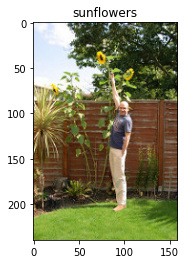

In [9]:
get_label_name = metadata.features['label'].int2str


image, label = next(iter(train_images))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

In [10]:



def augment(image, label):
  
  image = tf.image.random_flip_left_right(image)
  
  image = tf.image.random_contrast(image, lower=0.0, upper=1.0)
  
  return image,label

In [11]:
IMG_SIZE = 224 

def format_example(image, label):
  image = tf.cast(image, tf.float32)

  image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
  return image, label

image.shape

train = train_images.map(format_example)
val = val_images.map(format_example)
test = test_images.map(format_example)

In [12]:
SHUFFLE_BUFFER_SIZE = 1024
BATCH_SIZE = 32

train = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
val = val.batch(BATCH_SIZE)
test = test.batch(1)

train = train.prefetch(tf.data.experimental.AUTOTUNE)

test

<BatchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>

In [13]:
model = keras.Sequential([
    keras.layers.Conv2D(64, (3, 3), padding = "same", input_shape=(224,224,3)),
    keras.layers.BatchNormalization(center=True, scale=True),
    keras.layers.Activation('relu'),
    keras.layers.MaxPool2D(pool_size=[2,2]),

    
    keras.layers.Conv2D(32, (3,3), padding = "same"),
    keras.layers.BatchNormalization(center=True, scale=True),
    keras.layers.Activation('relu'),
    keras.layers.MaxPool2D(pool_size=[2,2]),
    keras.layers.Dropout(0.2),

    keras.layers.Conv2D(32, (3,3), padding = "same"),
    keras.layers.BatchNormalization(center=True, scale=True),
    keras.layers.Activation('relu'),
    keras.layers.MaxPool2D(pool_size=[2,2]),
    keras.layers.Dropout(0.2),


    keras.layers.Flatten(),
    keras.layers.Dense(64),
    keras.layers.Activation('relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(metadata.features['label'].num_classes, activation='softmax'),
    ])


model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 224, 224, 64)      1792      
_________________________________________________________________
batch_normalization_3 (Batch (None, 224, 224, 64)      256       
_________________________________________________________________
activation_4 (Activation)    (None, 224, 224, 64)      0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 112, 112, 32)      18464     
_________________________________________________________________
batch_normalization_4 (Batch (None, 112, 112, 32)      128       
_________________________________________________________________
activation_5 (Activation)    (None, 112, 112, 32)      0

In [16]:

model.compile(optimizer='sgd', loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [17]:
history = model.fit(train, epochs=10, validation_data=val)

Epoch 1/10
92/92 [==============================] - 4s 41ms/step - loss: 0.8688 - accuracy: 0.6502 - val_loss: 0.9143 - val_accuracy: 0.6294
Epoch 2/10
92/92 [==============================] - 4s 39ms/step - loss: 0.8703 - accuracy: 0.6345 - val_loss: 1.0227 - val_accuracy: 0.6240
Epoch 3/10
92/92 [==============================] - 4s 39ms/step - loss: 0.8441 - accuracy: 0.6536 - val_loss: 0.9479 - val_accuracy: 0.6267
Epoch 4/10
92/92 [==============================] - 4s 39ms/step - loss: 0.8076 - accuracy: 0.6669 - val_loss: 1.0236 - val_accuracy: 0.6185
Epoch 5/10
92/92 [==============================] - 4s 39ms/step - loss: 0.7587 - accuracy: 0.6924 - val_loss: 0.8980 - val_accuracy: 0.6431
Epoch 6/10
92/92 [==============================] - 4s 39ms/step - loss: 0.7445 - accuracy: 0.7078 - val_loss: 1.0787 - val_accuracy: 0.6022
Epoch 7/10
92/92 [==============================] - 4s 40ms/step - loss: 0.6871 - accuracy: 0.7262 - val_loss: 1.2362 - val_accuracy: 0.5777
Epoch 8/10
92

In [ ]:
plt.figure(1)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
# plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.title("Accuracy")

plt.figure(2)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
# plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.title("Loss")


In [18]:
_, baseline_accuracy= model.evaluate(test,verbose=1)

_, baseline_file = tempfile.mkstemp('.h5')
tf.keras.models.save_model(model, baseline_file, include_optimizer=False)
print('Saved baseline model to:', baseline_file)

367/367 [==============================] - 1s 2ms/step - loss: 0.7942 - accuracy: 0.6866
Saved baseline model to: /tmp/tmpp3pufnku.h5


In [19]:
import tensorflow_model_optimization as tfmot

prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

# Compute end step to finish pruning after 2 epochs.
batch_size = 128
epochs = 10
validation_split = 0.2 # 10% of training set will be used for validation set. 

num_images = num_train * (1 - validation_split)
end_step = np.ceil(num_images / batch_size).astype(np.int32) * epochs

# Define model for pruning.
pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,
                                                               final_sparsity=0.80,
                                                               begin_step=0,
                                                               end_step=end_step),
    
}

model_for_pruning = prune_low_magnitude(model, **pruning_params)

# `prune_low_magnitude` requires a recompile.
model_for_pruning.compile(optimizer='sgd', loss="sparse_categorical_crossentropy", metrics=["accuracy"])


model_for_pruning.summary()

Instructions for updating:
Please use `layer.add_weight` method instead.


Instructions for updating:
Please use `layer.add_weight` method instead.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
prune_low_magnitude_conv2d_3 (None, 224, 224, 64)      3522      
_________________________________________________________________
prune_low_magnitude_batch_no (None, 224, 224, 64)      257       
_________________________________________________________________
prune_low_magnitude_activati (None, 224, 224, 64)      1         
_________________________________________________________________
prune_low_magnitude_max_pool (None, 112, 112, 64)      1         
_________________________________________________________________
prune_low_magnitude_conv2d_4 (None, 112, 112, 32)      36898     
_________________________________________________________________
prune_low_magnitude_batch_no (None, 112, 112, 32)      129       
_________________________________________________________________
prune_low_magnitude_activati (None, 112, 112, 32)      1

In [20]:
logdir =str( pathlib.Path(os.getcwd( )+"/extra"))

callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
  tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
]
  
hist_quant = model_for_pruning.fit(train, epochs=epochs, validation_data=val,    callbacks=callbacks)

Epoch 1/10
 1/92 [..............................] - ETA: 0s - loss: 0.7142 - accuracy: 0.6562WARNING:tensorflow:From /home/abhishek/anaconda3/lib/python3.8/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.


Instructions for updating:
use `tf.profiler.experimental.stop` instead.


 2/92 [..............................] - ETA: 3s - loss: 0.8693 - accuracy: 0.6406WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0220s vs `on_train_batch_end` time: 0.0594s). Check your callbacks.


92/92 [==============================] - 5s 50ms/step - loss: 0.6042 - accuracy: 0.7531 - val_loss: 1.0572 - val_accuracy: 0.6376
Epoch 2/10
92/92 [==============================] - 5s 49ms/step - loss: 0.7749 - accuracy: 0.6894 - val_loss: 1.0108 - val_accuracy: 0.6185
Epoch 3/10
92/92 [==============================] - 4s 47ms/step - loss: 0.6807 - accuracy: 0.7360 - val_loss: 1.0034 - val_accuracy: 0.5831
Epoch 4/10
92/92 [==============================] - 4s 46ms/step - loss: 0.6489 - accuracy: 0.7391 - val_loss: 1.0256 - val_accuracy: 0.6131
Epoch 5/10
92/92 [==============================] - 4s 47ms/step - loss: 0.6240 - accuracy: 0.7524 - val_loss: 0.8598 - val_accuracy: 0.6785
Epoch 6/10
92/92 [==============================] - 4s 45ms/step - loss: 0.5760 - accuracy: 0.7772 - val_loss: 0.8980 - val_accuracy: 0.6757
Epoch 7/10
92/92 [==============================] - 4s 45ms/step - loss: 0.5702 - accuracy: 0.7759 - val_loss: 0.9399 - val_accuracy: 0.6621
Epoch 8/10
92/92 [======

In [ ]:
plt.figure(1)
plt.plot(hist_quant.history['accuracy'], label='accuracy')
plt.plot(hist_quant.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
# plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.title("Accuracy")

plt.figure(2)
plt.plot(hist_quant.history['loss'], label='loss')
plt.plot(hist_quant.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
# plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.title("Loss")


In [21]:
_, model_for_pruning_accuracy = model_for_pruning.evaluate(test, verbose=1)

print('Baseline test accuracy:', baseline_accuracy) 
print('Pruned test accuracy:', model_for_pruning_accuracy)

Baseline test accuracy: [0.7942211627960205, 0.6866484880447388]
Pruned test accuracy: [0.8285245299339294, 0.692098081111908]


In [22]:
model_for_export = tfmot.sparsity.keras.strip_pruning(model_for_pruning)

_, pruned_keras_file = tempfile.mkstemp('.h5')
tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)
print('Saved pruned Keras model to:', pruned_keras_file)

Saved pruned Keras model to: /tmp/tmpxnh24kyu.h5


In [23]:
converter = tf.lite.TFLiteConverter.from_keras_model(model_for_export)
pruned_tflite_model = converter.convert()

_, pruned_tflite_file = tempfile.mkstemp('.tflite')

with open(pruned_tflite_file, 'wb') as f:
  f.write(pruned_tflite_model)

print('Saved pruned TFLite model to:', pruned_tflite_file)



Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


INFO:tensorflow:Assets written to: /tmp/tmp_qtb_nak/assets


INFO:tensorflow:Assets written to: /tmp/tmp_qtb_nak/assets


Saved pruned TFLite model to: /tmp/tmpuhvkvj_d.tflite


In [24]:
def get_gzipped_model_size(file):
    # Returns size of gzipped model, in bytes.
    import os
    import zipfile

    _, zipped_file = tempfile.mkstemp('.zip')
    with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
        f.write(file)

    mbsize = os.path.getsize(zipped_file)/ (1024 * 1024);
    return  mbsize


In [25]:
print("Size of gzipped baseline Keras model: %.2f Mb" % (get_gzipped_model_size(baseline_file)))
print("Size of gzipped pruned Keras model: %.2f Mb" % (get_gzipped_model_size(pruned_keras_file)))
print("Size of gzipped pruned TFlite model: %.2f Mb" % (get_gzipped_model_size(pruned_tflite_file)))



Size of gzipped baseline Keras model: 5.77 Mb
Size of gzipped pruned Keras model: 2.01 Mb
Size of gzipped pruned TFlite model: 1.95 Mb


In [26]:
converter = tf.lite.TFLiteConverter.from_keras_model(model_for_export)
converter.target_spec.supported_types = [tf.float16]
quantized_and_pruned_tflite_model = converter.convert()

_, quantized_and_pruned_tflite_file = tempfile.mkstemp('.tflite')

with open(quantized_and_pruned_tflite_file, 'wb') as f:
  f.write(quantized_and_pruned_tflite_model)

print('Saved quantized and pruned TFLite model to:', quantized_and_pruned_tflite_file)

print("Size of gzipped baseline Keras model: %.2f Mb" % (get_gzipped_model_size(baseline_file)))
print("Size of gzipped pruned and quantized TFlite model: %.2f Mb" % (get_gzipped_model_size(quantized_and_pruned_tflite_file)))



INFO:tensorflow:Assets written to: /tmp/tmp_j6xx5un/assets


INFO:tensorflow:Assets written to: /tmp/tmp_j6xx5un/assets


Saved quantized and pruned TFLite model to: /tmp/tmpz_zn4_dp.tflite
Size of gzipped baseline Keras model: 5.77 Mb
Size of gzipped pruned and quantized TFlite model: 1.95 Mb


In [27]:
ds = tfds.as_numpy(train)
train1 =[]
for ex in ds:
  # `{'image': np.array(shape=(28, 28, 1)), 'labels': np.array(shape=())}`
  train1.append(ex)

In [28]:
def representative_data_gen():
  for input_value in tf.data.Dataset.from_tensor_slices(np.array(train1[0][0])).batch(1).take(1):
    yield [input_value]

In [29]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen

# Ensure that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# Set the input and output tensors to uint8 (APIs added in r2.3)
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8
quantized_and_pruned_tflite_model1 = converter.convert()

_, quantized_and_pruned_tflite_file1 = tempfile.mkstemp('.tflite')

with open(quantized_and_pruned_tflite_file1, 'wb') as f:
  f.write(quantized_and_pruned_tflite_model1)

print('Saved quantized and pruned TFLite model to:', quantized_and_pruned_tflite_file1)

print("Size of gzipped baseline Keras model: %.2f Mb" % (get_gzipped_model_size(baseline_file)))
print("Size of gzipped pruned and quantized TFlite model: %.2f Mb" % (get_gzipped_model_size(quantized_and_pruned_tflite_file1)))

INFO:tensorflow:Assets written to: /tmp/tmpu_ioxbfb/assets


INFO:tensorflow:Assets written to: /tmp/tmpu_ioxbfb/assets


Saved quantized and pruned TFLite model to: /tmp/tmp_osd0mmp.tflite
Size of gzipped baseline Keras model: 5.77 Mb
Size of gzipped pruned and quantized TFlite model: 0.52 Mb


In [30]:
def run_tflite_model(tflite_file, test_image_indices):
  global test
  ds = tfds.as_numpy(test)
  test1 =[]
  for ex in ds:
      # `{'image': np.array(shape=(28, 28, 1)), 'labels': np.array(shape=())}`
    test1.append(ex)
  # Initialize the interpreter
  interpreter = tf.lite.Interpreter(model_content=tflite_file)
  interpreter.allocate_tensors()

  input_details = interpreter.get_input_details()[0]
  output_details = interpreter.get_output_details()[0]

  predictions = np.zeros((len(test_image_indices),), dtype=int)
  for i, test_image_index in enumerate(test_image_indices):
    
    test_image = test1[test_image_index][0]
    test_label = test1[test_image_index][1]
#     print(test_image.shape)
    # Check if the input type is quantized, then rescale input data to uint8
    if input_details['dtype'] == np.uint8:
      input_scale, input_zero_point = input_details["quantization"]
      test_image = test_image / input_scale + input_zero_point

#     test_image = np.expand_dims(test_image, axis=0).astype(input_details["dtype"])
    interpreter.set_tensor(input_details["index"], test_image.astype(input_details["dtype"]))
    interpreter.invoke()
    output = interpreter.get_tensor(output_details["index"])[0]

    predictions[i] = output.argmax()
    # print(str(predictions[i]))
  return predictions

In [31]:
def evaluate_model_int(tflite_file, model_type):
  global test
  global test

  test_image_indices = range(int(num_test))
  predictions = run_tflite_model(tflite_file, test_image_indices)

 
  return predictions

In [32]:
predict= evaluate_model_int(quantized_and_pruned_tflite_model1, model_type="Quantized")


In [37]:
ds = tfds.as_numpy(test)
test1 =[]
for ex in ds:
  # `{'image': np.array(shape=(28, 28, 1)), 'labels': np.array(shape=())}`
    test1.append(ex)

accurate_count = 0
accuracy = 0 
for index in range(len(predict)):
  # data = np.argmax(predictions_int8[index])
  if predict[index] == test1[index][1][0]:
    accurate_count += 1
accuracy = accurate_count * 1.0 / len(predict)


Accuracy using  int 8 quantization on tflite file is: 0.6811989100817438
